# Inference Framework for Segregation Measures: Spatial Permutation Approach 

In [1]:
import pandas as pd
import pysal as ps
import geopandas as gpd
import scipy
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage.interpolation import shift

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


### Reading the entire dataset of Census

In [2]:
census_2010 = pd.read_csv("data/std_2010_fullcount.csv", encoding = "ISO-8859-1", sep = ",")
census_2010.head()

trtid10 state                county               tract  pop10  nhwht10  \
0  1001020100    AL        Autauga County    Census Tract 201   1912     1601   
1  6083002402    CA  Santa Barbara County  Census Tract 24.02  11406     1980   
2  1001020200    AL        Autauga County    Census Tract 202   2170      844   
3  6083002102    CA  Santa Barbara County  Census Tract 21.02   2084      853   
4  1001020300    AL        Autauga County    Census Tract 203   3373     2538   

   nhblk10  ntv10  asian10  hisp10     ...       a15hsp10  a60hsp10  ageasn10  \
0      228     21       16      44     ...             14         2        14   
1      207     54      703    8439     ...           2972       414       624   
2     1226      9       13      75     ...             14         1         5   
3       24     24       88    1088     ...            342        84        61   
4      668     30       42      87     ...             34         9        22   

   a15asn10  a60asn10  agentv10  a15ntv10  a60ntv10  globd10      globg10  
0         4         1        13         1         3       bw  White Black  
1       119        75        26         4         3      wha   Dual immig  
2         0         0         5         3         1       bw  White Black  
3         4        16        11         0         4      wha   Dual immig  
4         2         7         9         1         3       bw  White Black  

[5 rows x 47 columns]

This is a Inference Framework for segregation for non-hispanic black people for the Riverside County. So, let's just filter the data that we need: 

In [3]:
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10','tract','pop10','nhblk10']]

In [4]:
df.head()

trtid10                tract  pop10  nhblk10
5727  6065042012  Census Tract 420.12   6242      677
5729  6065041911  Census Tract 419.11  10258      844
5731  6065041910  Census Tract 419.10   6342      405
5733  6065040816  Census Tract 408.16   2594      346
5735  6065040815  Census Tract 408.15   3586      429

### Reading the apropriate map file and Merging with the data

In [6]:
map_gpd = gpd.read_file("shapefiles/06065_Riverside_County.shp")
map_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 13 columns):
STATEFP10     453 non-null object
COUNTYFP10    453 non-null object
TRACTCE10     453 non-null object
GEOID10       453 non-null object
NAME10        453 non-null object
COUNTY_ID     453 non-null object
county_id2    453 non-null int64
COUNTYNS10    453 non-null int64
NAME10_COU    453 non-null object
GEOID_MSA     453 non-null int64
NAME_MSA      453 non-null object
STATES_MSA    453 non-null object
geometry      453 non-null object
dtypes: int64(3), object(10)
memory usage: 46.1+ KB


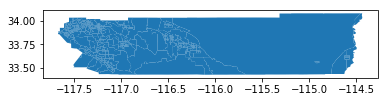

In [7]:
%matplotlib inline
map_gpd.plot()

It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.

In [8]:
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
df_map = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')

Extracting only the columns that the inference framework will use.

In [9]:
df_mp = df_map[['GEOID10', 'tract', 'geometry', 'pop10', 'nhblk10']]
df_mp.head()

GEOID10                tract  \
0  06065042012  Census Tract 420.12   
1  06065041911  Census Tract 419.11   
2  06065041910  Census Tract 419.10   
3  06065040816  Census Tract 408.16   
4  06065040815  Census Tract 408.15   

                                            geometry  pop10  nhblk10  
0  POLYGON ((-117.319414 33.902109, -117.322528 3...   6242      677  
1  POLYGON ((-117.504056 33.800257, -117.502758 3...  10258      844  
2  POLYGON ((-117.472451 33.762031, -117.475661 3...   6342      405  
3  POLYGON ((-117.5285 33.89736, -117.529425 33.8...   2594      346  
4  POLYGON ((-117.501299 33.89424899999999, -117....   3586      429

# First measure of segregation: Uneveness

According to (The Dimensions of Residential Segregation paper), the eveness refers to the differential distribution of two social groups among areal units in space. The chosen minority group, non-hispanic Black people in this case, is said to be segregated if it is unevenly distributed over  areal units. 

The percentage (%) of black people in Riverside County is:

In [10]:
df_mp.nhblk10.sum()/df_mp.pop10.sum() * 100

6.780106875967339

However, inside each census tract, there are some level of variation of this percentage:

In [11]:
(df_mp.nhblk10/df_mp.pop10 * 100).head(10)

0    10.845883
1     8.227725
2     6.385998
3    13.338473
4    11.963190
5    14.784609
6     3.486842
7     1.350575
8    12.102497
9     6.090026
dtype: float64

In order to calculate D, we have to know ti (simple the tract population), pi, P and T.

In [12]:
T = df_mp.pop10.sum()
P = df_mp.nhblk10.sum() / T
df_mp['ti'] = df_mp.pop10
df_mp['pi'] = df_mp.nhblk10 /df_mp.pop10
df_mp.head()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


GEOID10                tract  \
0  06065042012  Census Tract 420.12   
1  06065041911  Census Tract 419.11   
2  06065041910  Census Tract 419.10   
3  06065040816  Census Tract 408.16   
4  06065040815  Census Tract 408.15   

                                            geometry  pop10  nhblk10     ti  \
0  POLYGON ((-117.319414 33.902109, -117.322528 3...   6242      677   6242   
1  POLYGON ((-117.504056 33.800257, -117.502758 3...  10258      844  10258   
2  POLYGON ((-117.472451 33.762031, -117.475661 3...   6342      405   6342   
3  POLYGON ((-117.5285 33.89736, -117.529425 33.8...   2594      346   2594   
4  POLYGON ((-117.501299 33.89424899999999, -117....   3586      429   3586   

         pi  
0  0.108459  
1  0.082277  
2  0.063860  
3  0.133385  
4  0.119632

In [13]:
D = (((df_mp.pop10 * abs(df_mp.pi - P)))/ (2 * T * P * (1 - P))).sum()
D

0.31565682496226544

 The interpretation of this value is that 31.57% of the black population would have to move to reach eveness in the Riverside County.

# Second measure of segregation: Isolation

Isolation assess how much a minority group is only exposed to the same group. In other words, how much they only interact the members of the group that they belong.

The formula takes in consideration the count number (xi) of the minority group and the total population of this minority (X).

In [14]:
df_mp['xi'] = df_mp.nhblk10
X = df_mp['xi'].sum()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
xPx = ((df_mp.xi / X) * (df_mp.xi / df_mp.ti)).sum()
xPx

0.11321482777341298

The interpretation of this number is that if you randomly pick a X member of a specific area, there is 11.32% of probability that this member shares a unit with another X member.

# Third measure of segregation: Clustering

The clustering measure assess the extent to which areal units inhabited by minority members adjoin one another, or cluster, in space. This Spatial Proximity Index (SP) is evaluated between two distinct groups X (non-hispanic black) and Y (other than non-hipanic black).

In [16]:
df_mp['yi'] = df_mp.pop10 - df_mp.nhblk10
Y = df_mp.yi.sum()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_mp.head()

GEOID10                tract  \
0  06065042012  Census Tract 420.12   
1  06065041911  Census Tract 419.11   
2  06065041910  Census Tract 419.10   
3  06065040816  Census Tract 408.16   
4  06065040815  Census Tract 408.15   

                                            geometry  pop10  nhblk10     ti  \
0  POLYGON ((-117.319414 33.902109, -117.322528 3...   6242      677   6242   
1  POLYGON ((-117.504056 33.800257, -117.502758 3...  10258      844  10258   
2  POLYGON ((-117.472451 33.762031, -117.475661 3...   6342      405   6342   
3  POLYGON ((-117.5285 33.89736, -117.529425 33.8...   2594      346   2594   
4  POLYGON ((-117.501299 33.89424899999999, -117....   3586      429   3586   

         pi   xi    yi  
0  0.108459  677  5565  
1  0.082277  844  9414  
2  0.063860  405  5937  
3  0.133385  346  2248  
4  0.119632  429  3157

In addition, we need to calculate the pairwise distance dij in order to calculate cij = exp(-dij) which is a decreasing function of the distance. For the distance diagonal we take dii = (0.6 ai) ^ 0.5

In [18]:
df_mp['c_lons'] = df_mp.centroid.map(lambda p: p.x)
df_mp['c_lats'] = df_mp.centroid.map(lambda p: p.y)
dist = euclidean_distances(df_mp[['c_lons','c_lats']])
np.fill_diagonal(dist, val = (0.6*df_mp.area)**(1/2))
c = np.exp(-dist)
c

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[0.987542  , 0.78443107, 0.80834959, ..., 0.63855674, 0.69032011,
        0.69299803],
       [0.78443107, 0.9379624 , 0.9574637 , ..., 0.55125288, 0.60088803,
        0.60881703],
       [0.80834959, 0.9574637 , 0.97471765, ..., 0.5523936 , 0.60186742,
        0.60888152],
       ...,
       [0.63855674, 0.55125288, 0.5523936 , ..., 0.99126376, 0.91737242,
        0.90354521],
       [0.69032011, 0.60088803, 0.60186742, ..., 0.91737242, 0.99001633,
        0.97872376],
       [0.69299803, 0.60881703, 0.60888152, ..., 0.90354521, 0.97872376,
        0.98945207]])

In [19]:
Pxx = ((np.array(df_mp.xi) * c).T * np.array(df_mp.xi)).sum() / X**2
Pyy = ((np.array(df_mp.yi) * c).T * np.array(df_mp.yi)).sum() / Y**2
RCL = Pxx / Pyy - 1
RCL

0.12418089857347714

# Fourth measure of segregation: Concentration

This measure estimate the amount of phsical space that the minority people occupies in relation to the other group.

In [20]:
A = df_mp.area.sum()
DEL = 1/2 * abs(df_mp.xi / X - df_mp.area / A).sum()

In [21]:
DEL

0.8367330649317353

# Fifth measure of segregation: Centralization

This measure estimate how far from the central business district the minority people is.

First we need to calculate the distance of each tract from what is considered the central business center. However, this center is not well-defined in first hand. In this case, we make the hyhotesis that the center latitudes and longitudes is an approximation of this considered *center*.

In [22]:
df_mp['center_lon']  = df_mp.c_lons.mean()
df_mp['center_lat']  = df_mp.c_lats.mean()
df_mp['center_dist'] = np.sqrt((df_mp.c_lons - df_mp.center_lon)**2 + (df_mp.c_lats - df_mp.center_lat)**2)
df_mp_sort_cent = df_mp.sort_values('center_dist')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Calculating the cumulative proportion of the variables ordered by the distance of the center. These measures are used to calculate either Absolute Centralization Index (ACE) or Relative Centralizaiton Index (RCE).

In [23]:
df_mp_sort_cent['Xi'] = np.cumsum(df_mp_sort_cent.xi) / X
df_mp_sort_cent['Yi'] = np.cumsum(df_mp_sort_cent.yi) / Y
df_mp_sort_cent['Ai'] = np.cumsum(df_mp_sort_cent.area) / A

These new variables reach the value of one at the end of the dataset.

In [24]:
df_mp_sort_cent.tail()

GEOID10                tract  \
420  06065046103  Census Tract 461.03   
418  06065046200     Census Tract 462   
421  06065046101  Census Tract 461.01   
173  06065047000     Census Tract 470   
172  06065940100    Census Tract 9401   

                                              geometry  pop10  nhblk10    ti  \
420  POLYGON ((-114.605968 33.632046, -114.599818 3...   3030      104  3030   
418  POLYGON ((-114.570768 33.6108, -114.570684 33....   3341      516  3341   
421  POLYGON ((-114.596796 33.610354, -114.596858 3...   3060      192  3060   
173  POLYGON ((-114.511972 33.735019, -114.512348 3...   1749       81  1749   
172  POLYGON ((-114.504839 33.760205, -114.516989 3...    166        3   166   

           pi   xi    yi      c_lons     c_lats  center_lon  center_lat  \
420  0.034323  104  2926 -114.597233  33.624902 -117.015209    33.80972   
418  0.154445  516  2825 -114.596687  33.599470 -117.015209    33.80972   
421  0.062745  192  2868 -114.583893  33.614224 -117.015209    33.80972   
173  0.046312   81  1668 -114.561894  33.620277 -117.015209    33.80972   
172  0.018072    3   163 -114.491170  33.965624 -117.015209    33.80972   

     center_dist        Xi        Yi        Ai  
420     2.425029  0.994665  0.996314  0.987896  
418     2.427644  0.998141  0.997698  0.988516  
421     2.439163  0.999434  0.999103  0.988619  
173     2.460619  0.999980  0.999920  0.995967  
172     2.528849  1.000000  1.000000  1.000000

In [25]:
ACE = (shift(df_mp_sort_cent.Xi, 1, cval=np.NaN) * df_mp_sort_cent.Ai).sum() - \
      (df_mp_sort_cent.Xi * shift(df_mp_sort_cent.Ai, 1, cval=np.NaN)).sum()
ACE

0.6416113799795511

# Constructing the overall segregation measure for the County: aggregating the measures

In [26]:
SM = np.mean([D, xPx, RCL, DEL, ACE])
SM

0.4062793992440884

# Function that calculates the segregation measure for a specific group

In [27]:
def calculate_segregation(data, group_pop_var, total_pop_var):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    '''
    
    # Uneveness
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    data['ti'] = data.total_pop_var
    data['pi'] = data.group_pop_var / data.total_pop_var
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    # Isolation
    data['xi'] = data.group_pop_var
    X = data['xi'].sum()
    xPx = ((data.xi / X) * (data.xi / data.ti)).sum()
    
    # Clustering
    data['yi'] = data.total_pop_var - data.group_pop_var
    Y = data.yi.sum()
    data['c_lons'] = data.centroid.map(lambda p: p.x)
    data['c_lats'] = data.centroid.map(lambda p: p.y)
    dist = euclidean_distances(data[['c_lons','c_lats']])
    np.fill_diagonal(dist, val = (0.6*data.area)**(1/2))
    c = np.exp(-dist)
    Pxx = ((np.array(data.xi) * c).T * np.array(data.xi)).sum() / X**2
    Pyy = ((np.array(data.yi) * c).T * np.array(data.yi)).sum() / Y**2
    RCL = Pxx / Pyy - 1

    # Concentration
    A = data.area.sum()
    DEL = 1/2 * abs(data.xi / X - data.area / A).sum()
    
    # Centralization
    data['center_lon']  = data.c_lons.mean()
    data['center_lat']  = data.c_lats.mean()
    data['center_dist'] = np.sqrt((data.c_lons - data.center_lon)**2 + (data.c_lats - data.center_lat)**2)
    data_sort_cent = data.sort_values('center_dist')
    
    data_sort_cent['Xi'] = np.cumsum(data_sort_cent.xi) / X
    data_sort_cent['Yi'] = np.cumsum(data_sort_cent.yi) / Y
    data_sort_cent['Ai'] = np.cumsum(data_sort_cent.area) / A
    
    ACE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Ai).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Ai, 1, cval=np.NaN)).sum()
    
    # Aggregating
    SM = np.mean([D, xPx, RCL, DEL, ACE])
    
    return SM

Testing the function for the hispanic group.

In [28]:
df_hisp = census_2010.loc[census_2010.county == "Riverside County"][['trtid10','tract','pop10', 'hisp10']]
df_map_hisp = map_gpd.merge(df_hisp, left_on = 'INTGEOID10', right_on = 'trtid10')
calculate_segregation(df_map_hisp, 'hisp10', 'pop10')

0.4472686189233796